In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install -U accelerate
!pip install -U transformers
!pip install transformers datasets torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1b4e629ef38f31dcf7de9cdc65d5b643cb4e154a1be232ac430340141208c56b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
import json
import torch
import os
from datasets import load_dataset, Dataset, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq, TrainerCallback
from sklearn.model_selection import train_test_split
from datasets import load_metric
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import numpy as np  # Add this import statement

In [5]:
from transformers import TrainerCallback


In [6]:
import numpy as np  # Add this import statement


In [7]:
with open('/content/scope_req_dataset_extended.json') as f:
    data = json.load(f)

In [8]:
# Convert the dataset to a format suitable for fine-tuning
def convert_to_text(record):
    scope = record['scope']
    functional_reqs = "\n".join(record['functional_requirements'])
    non_functional_reqs = "\n".join(record['non_functional_requirements'])
    return {
        "input": f"Scope: {scope}",
        "output": f"Functional Requirements:\n{functional_reqs}\nNon-Functional Requirements:\n{non_functional_reqs}"
    }

In [9]:
converted_data = [convert_to_text(record) for record in data]

# Create a Dataset object
dataset = Dataset.from_dict({
    'input': [d['input'] for d in converted_data],
    'output': [d['output'] for d in converted_data]
})

In [10]:
# converted_data

In [11]:
# Split the dataset into training, validation, and test sets
train_test_data = dataset.train_test_split(test_size=0.2, seed=42)
test_valid_data = train_test_data['test'].train_test_split(test_size=0.5, seed=42)

dataset_dict = DatasetDict({
    'train': train_test_data['train'],
    'validation': test_valid_data['train'],
    'test': test_valid_data['test']
})

In [12]:
# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [13]:
# Prepare the dataset for T5
def tokenize_function(examples):
    model_inputs = tokenizer(examples['input'], max_length=512, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['output'], max_length=512, truncation=True, padding='max_length')
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [14]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=["input", "output"])

# Define data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [15]:
# # Set up training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     overwrite_output_dir=True,
#     num_train_epochs=4,  # Increase for better training
#     per_device_train_batch_size=2,
#     save_steps=10_000,
#     save_total_limit=2,
#     logging_dir='./logs',
#     evaluation_strategy="epoch",
# )

# # Initialize Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=tokenized_datasets['train'],
#     eval_dataset=tokenized_datasets['validation'],
# )

# Step 1: Modify TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=32,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir='./logs',
    eval_strategy="epoch",
    learning_rate=1e-5
)

# Add history attribute
training_args.history = {
    'train_loss': [],
    'eval_loss': [],
    'train_accuracy': [],
    'eval_accuracy': []
}

class HistoryCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                args.history['train_loss'].append(logs['loss'])
            if 'eval_loss' in logs:
                args.history['eval_loss'].append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                args.history['eval_accuracy'].append(logs['eval_accuracy'])
            if 'accuracy' in logs:
                args.history['train_accuracy'].append(logs['accuracy'])

    def on_epoch_end(self, args, state, control, **kwargs):
        train_dataloader = kwargs.get('train_dataloader')
        if train_dataloader is not None:
            model = kwargs.get('model')
            model.eval()
            total, correct = 0, 0
            for batch in train_dataloader:
                inputs, labels = batch['input_ids'].to(args.device), batch['labels'].to(args.device)
                with torch.no_grad():
                    outputs = model(input_ids=inputs, labels=labels)
                logits = outputs.logits
                predictions = np.argmax(logits.cpu().numpy(), axis=-1)
                labels = labels.cpu().numpy()
                correct += (predictions == labels).sum()
                total += labels.size
            train_accuracy = correct / total
            args.history['train_accuracy'].append(train_accuracy)
            model.train()

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    if logits.ndim == 3:
        logits = logits.reshape(-1, logits.shape[-1])
        labels = labels.reshape(-1)
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {'accuracy': accuracy}

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

class CustomTrainer(Trainer):
    def create_optimizer_and_scheduler(self, num_training_steps: int):
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.args.learning_rate)
        self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=6, T_mult=2)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    callbacks=[HistoryCallback()],
    compute_metrics=compute_metrics
)

In [16]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,6.382007,0.104427
2,No log,2.303892,0.614062
3,No log,1.827084,0.647005
4,No log,1.638905,0.673177
5,No log,1.611530,0.678516
6,No log,1.442118,0.699740
7,No log,1.350031,0.710938
8,No log,1.305882,0.716536
9,3.460000,1.288403,0.719141
10,3.460000,1.285117,0.719271


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,6.382007,0.104427
2,No log,2.303892,0.614062
3,No log,1.827084,0.647005
4,No log,1.638905,0.673177
5,No log,1.611530,0.678516
6,No log,1.442118,0.699740
7,No log,1.350031,0.710938
8,No log,1.305882,0.716536
9,3.460000,1.288403,0.719141
10,3.460000,1.285117,0.719271


TrainOutput(global_step=1984, training_loss=1.8830905729724514, metrics={'train_runtime': 2051.1726, 'train_samples_per_second': 1.935, 'train_steps_per_second': 0.967, 'total_flos': 2416344909742080.0, 'train_loss': 1.8830905729724514, 'epoch': 32.0})

In [17]:
# config = model.config
# # Save the fine-tuned model
# # model.save_pretrained('/content/drive/My Drive/T5_fine_tuned')
# # Save the model state explicitly
# torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/T5_fine_tuned_updated', 'pytorch_model.bin'))
# config.save_pretrained('/content/drive/My Drive/T5_fine_tuned_updated')
# tokenizer.save_pretrained('/content/drive/My Drive/T5_fine_tuned_updated')

In [19]:
# Evaluate the model using BLEU score
bleu = load_metric("bleu")

The repository for bleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
def compute_bleu_score(predictions, references):
    bleu.add_batch(predictions=predictions, references=references)
    return bleu.compute()

In [ ]:
class CustomStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.first_words = set()
        self.repeating_word_detected = False

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        decoded_output = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        lines = decoded_output.split('\n')

        for line in lines:
            if line.strip():  # Ensure the line is not empty
                first_word = line.split()[0]  # Get the first word
                print("First word:", first_word)  # Print the first word
                if first_word in self.first_words:
                    print("Repeating word detected:", first_word)  # Print if repeating word detected
                    self.repeating_word_detected = True
                    return True
                self.first_words.add(first_word)

        return False

In [20]:
# Generate predictions for the test set
def generate_requirements(scope, tokenizer, model):
    prompt = f"Scope: {scope}\nFunctional Requirements:\n"
    inputs = tokenizer(prompt, return_tensors='pt')

    if torch.cuda.is_available():
        inputs = {key: value.to('cuda') for key, value in inputs.items()}
        model.to('cuda')

    input_ids = inputs['input_ids']
    outputs = model.generate(
        input_ids,
        max_length=512,  # Adjust max length as needed
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text

In [21]:
predictions = []
references = []

for example in dataset_dict['test']:
    scope = example['input']
    reference = example['output']
    generated_text = generate_requirements(scope, tokenizer, model)

    predictions.append(generated_text.split())  # Tokenize the generated text
    references.append([reference.split()])  # Tokenize the reference text and nest it within a list

In [36]:
def compute_bleu_score(predictions, references):
    bleu.add_batch(predictions=predictions, references=references)
    return bleu.compute()

In [40]:
# Compute and print BLEU score
bleu_score = compute_bleu_score(predictions, references)
print("BLEU score:", bleu_score)

BLEU score: {'bleu': 0.09550591499865926, 'precisions': [0.29087098276665113, 0.12365591397849462, 0.06100422336931018, 0.037918040508714085], 'brevity_penalty': 1.0, 'length_ratio': 1.1875, 'translation_length': 4294, 'reference_length': 3616}


In [23]:
def generate_requirements_custom(scope, tokenizer, model, temperature=1.0, top_k=50, top_p=0.95):
    # Generate requirements using the fine-tuned model with custom sampling parameters
    prompt = f"Scope: {scope}\nFunctional Requirements:\n"
    inputs = tokenizer(prompt, return_tensors='pt')

    if torch.cuda.is_available():
        inputs = {key: value.to('cuda') for key, value in inputs.items()}
        model.to('cuda')

    input_ids = inputs['input_ids']
    outputs = model.generate(
        input_ids,
        max_length=512,  # Adjust max length as needed
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text

In [47]:
scope = "An AI-powered healthcare diagnosis system that assists doctors by providing probable diagnoses based on patient symptoms and history."
requirements = generate_requirements_custom(scope, tokenizer, model, temperature=0.7, top_k=30, top_p=0.9)
print(requirements)

Functional Requirements: Patients can create and manage their healthcare records using a variety of diagnostic tools. The system provides a variety of diagnostic options for determining probable diagnoses. The system provides tools for analyzing patient history and symptoms. Patients can create and manage their healthcare records using the system. The system provides tools for analyzing patient history and symptoms. The system provides tools for analyzing patient data and analyzing medical history. The system supports integration with other healthcare systems. Non-Functional Requirements: Performance: Ensures fast diagnostic response times. Scalability: Can handle growing numbers of users and users. Reliability: Ensures high availability and data consistency. Compliance: Adheres to healthcare standards and data privacy regulations.


In [44]:
# Example usage
scope = "A Pizza Restaurant system that assists customers to make orders and customize them, view menu, rate the food, and the admin can accept orders, and view statistics for orders."
requirements = generate_requirements(scope, tokenizer, model)
print(requirements)

Functional Requirements: Users can create and edit orders, customize menus, and view statistics for orders. The system supports ordering history, order history, and billing. The system supports ordering history, order history, and billing. Users can create and edit menus, view menus, and view statistics for orders. The system supports ordering history, order history, and billing. The system supports ordering history, order history, and billing. The system supports payment processing, billing, and billing. The system supports payment processing, and billing. Users can create and update orders, and update orders. The system supports payment history, and billing history. The system supports billing and billing. The system supports billing and billing. The system supports billing and billing. The system supports billing and billing. The system supports billing and billing. The system supports billing and billing. The system supports billing and billing. The system supports billing and bill

In [28]:
text = requirements

**Plots**

In [48]:
def extract_requirements(text, section_name):
    # Find the section name in the text and extract the content until the next section or end of text
    start_index = text.find(section_name)
    if start_index == -1:
        return ""
    end_index = len(text)
    if section_name == 'Functional Requirements:':
        next_section = 'Non-Functional Requirements:'
        next_index = text.find(next_section, start_index)
        if next_index != -1:
            end_index = next_index
    return text[start_index:end_index].strip()

def compute_bleu_rouge(requirements, converted_data):
    # Extract functional and non-functional requirements from requirements string
    functional_requirements = extract_requirements(requirements, 'Functional Requirements:')
    non_functional_requirements = extract_requirements(requirements, 'Non-Functional Requirements:')

    bleu_scores = []
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for record in converted_data:
        # Extract functional and non-functional requirements from converted_data
        gen_functional = extract_requirements(record['output'], 'Functional Requirements:')
        gen_non_functional = extract_requirements(record['output'], 'Non-Functional Requirements:')

        # Compute BLEU score for functional requirements
        ref_tokens = [functional_requirements.split()]
        gen_tokens = gen_functional.split()
        bleu_score = sentence_bleu(ref_tokens, gen_tokens)
        bleu_scores.append(bleu_score)

        # Compute BLEU score for non-functional requirements
        ref_tokens = [non_functional_requirements.split()]
        gen_tokens = gen_non_functional.split()
        bleu_score = sentence_bleu(ref_tokens, gen_tokens)
        bleu_scores.append(bleu_score)

        # Compute ROUGE scores for functional requirements
        rouge_score = rouge.score(functional_requirements, gen_functional)
        for key in rouge_scores.keys():
            rouge_scores[key].append(rouge_score[key].fmeasure)

        # Compute ROUGE scores for non-functional requirements
        rouge_score = rouge.score(non_functional_requirements, gen_non_functional)
        for key in rouge_scores.keys():
            rouge_scores[key].append(rouge_score[key].fmeasure)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge = {key: sum(scores) / len(scores) for key, scores in rouge_scores.items()}

    return avg_bleu, avg_rouge

avg_bleu, avg_rouge = compute_bleu_rouge(requirements, converted_data)

print("Average BLEU score:", avg_bleu)
print("Average ROUGE scores:", avg_rouge)

Average BLEU score: 0.06458787381545936
Average ROUGE scores: {'rouge1': 0.3457032810042496, 'rouge2': 0.16059182749521225, 'rougeL': 0.2883764677317741}


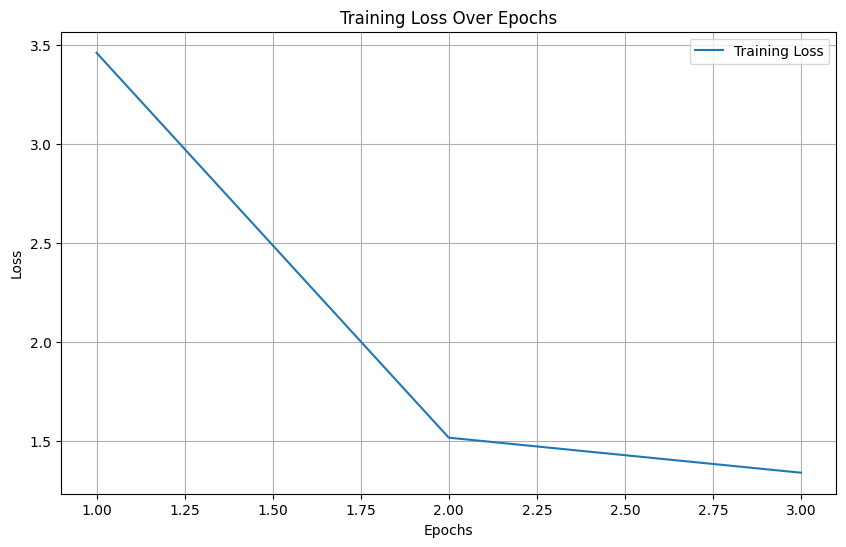

In [31]:
# Plot Training and Validation Loss Over Epochs
def plot_loss(training_args):
    train_loss = training_args.history["train_loss"]
    eval_loss = training_args.history["eval_loss"]
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label="Training Loss")
    # plt.plot(epochs, eval_loss, label="Validation Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(training_args)

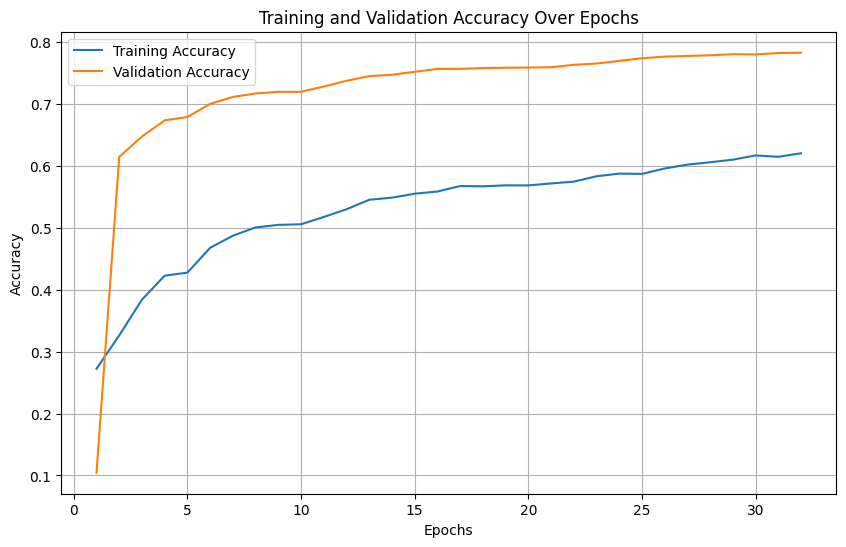

In [32]:
# Plot Training and Validation Accuracy Over Epochs
def plot_accuracy(training_args, save_path="/content/pngs/accuracy_plot.png"):
    train_acc = training_args.history["train_accuracy"]
    eval_acc = training_args.history["eval_accuracy"]
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label="Training Accuracy")
    plt.plot(epochs, eval_acc, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # plt.savefig(save_path)  # Save the figure
    plt.show()

plot_accuracy(training_args, save_path="/content/pngs/accuracy_plot.png")

In [ ]:
# Plot Training and Validation Accuracy Over Epochs
def plot_accuracy(training_args, save_path="/content/pngs/accuracy_plot.png"):
    train_acc = training_args.history["train_accuracy"]
    eval_acc = training_args.history["eval_accuracy"]

    # Debugging: Print lengths of accuracy lists
    print(f"Length of training accuracy history: {len(train_acc)}")
    print(f"Length of evaluation accuracy history: {len(eval_acc)}")

    if len(train_acc) == 0 or len(eval_acc) == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label="Training Accuracy")
    plt.plot(epochs, eval_acc, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # plt.savefig(save_path)
    plt.show()

# After training, call the plot function
plot_accuracy(training_args)

In [ ]:
# # Plot Precision, Recall, and F1-Score Over Epochs
# def plot_metrics(training_args):
#     train_precision = training_args.history["train_precision"]
#     train_recall = training_args.history["train_recall"]
#     train_f1 = training_args.history["train_f1"]
#     eval_precision = training_args.history["eval_precision"]
#     eval_recall = training_args.history["eval_recall"]
#     eval_f1 = training_args.history["eval_f1"]
#     epochs = range(1, len(train_precision) + 1)

#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, train_precision, label="Training Precision")
#     plt.plot(epochs, train_recall, label="Training Recall")
#     plt.plot(epochs, train_f1, label="Training F1-Score")
#     plt.plot(epochs, eval_precision, label="Validation Precision")
#     plt.plot(epochs, eval_recall, label="Validation Recall")
#     plt.plot(epochs, eval_f1, label="Validation F1-Score")
#     plt.title("Precision, Recall, and F1-Score Over Epochs")
#     plt.xlabel("Epochs")
#     plt.ylabel("Score")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_metrics(training_args)

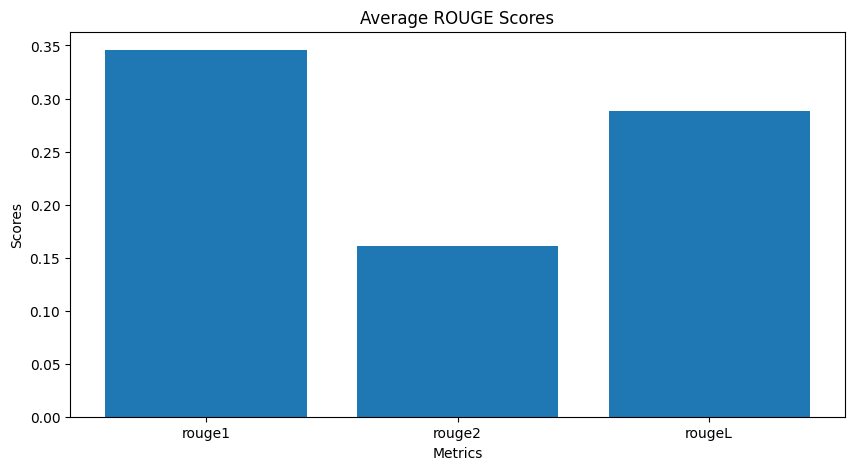

In [49]:
# Plot BLEU and ROUGE scores
def plot_bleu_rouge(scores, title):
    keys = list(scores.keys())
    values = [scores[key] for key in keys]

    plt.figure(figsize=(10, 5))
    plt.bar(keys, values)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(title)
    plt.show()

plot_bleu_rouge(avg_rouge, 'Average ROUGE Scores')